In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import shapely as shp
import geopandas as gpd
import math
import random
import scipy.stats as stats
from glob import glob
import os
#from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse

from functions import *

In [2]:
pal = sns.color_palette('GnBu', 5)
pal

[(0.8535178777393311, 0.9429757785467128, 0.8314186851211073),
 (0.7058823529411765, 0.8849673202614379, 0.7307189542483661),
 (0.4795847750865052, 0.7984621299500193, 0.7695501730103806),
 (0.2601307189542484, 0.6509803921568628, 0.7999999999999999),
 (0.07497116493656286, 0.4526874279123414, 0.6969319492502883)]

In [3]:
'''Import Data'''
path = './modeloutput' # use your path
modDat = pd.read_csv(path + '/rhino-data-looped/processedData.csv')

In [10]:
modDat.columns

Index(['stakes', 'northing', 'easting', 'zones', 'aspect', 'slope',
       'watershed', 'SYear', 'maxDepth', 'Stake_ID', 'OLS.Prediction.Ring.5',
       'DIST_FT', 'DIST_M', 'DBH_IN', 'DBH_CM', 'DIST_FT_SD', 'DIST_M_SD',
       'DBH_IN_SD', 'DBH_CM_SD', 'n', 'prop_Coniferous', 'Co', 'Mean', 'SD'],
      dtype='object')

In [13]:
#Rename
modDat['LAI'] = modDat['OLS.Prediction.Ring.5']

Text(0.5, 0, 'Volume [m3]')

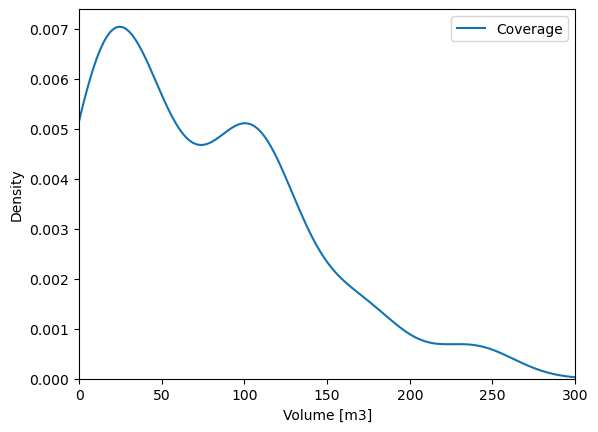

In [14]:
#General Site Statistics
fig, ax = plt.subplots(1, 1)
sns.kdeplot(data = modDat, x="Mean", label = 'Coverage', color = pal[4], ax = ax)
ax.legend()
ax.set_xlim(0, 300)
#ax.set_ylim(0, 200)
ax.set_xlabel('Volume [m3]')

(0.0, 243.46781166666668)

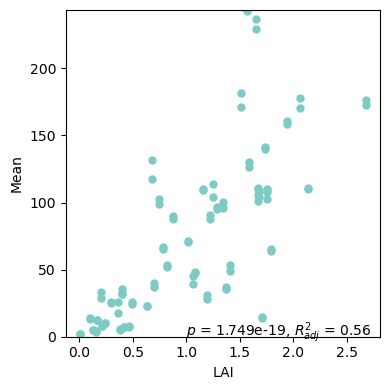

In [19]:
#Correlation with LAI
fig, ax1 = plt.subplots(1, 1, figsize = (4, 4), 
                sharex = True,  
                layout = 'tight')

#data spread
sns.scatterplot(data = modDat, x = 'LAI', y = 'Mean',
                color = pal[2], linewidth = 0,
                ax = ax1)


#model labels
lai_pCover = smf.ols('Mean ~ LAI', data = modDat).fit()
ax1.text(1, 0.45, r'$ p $ = ' + '{:0.3e}'.format(lai_pCover.pvalues.LAI) + r', $ R_{adj}^2 $ = ' + str(round_sig(lai_pCover.rsquared_adj, 2)))

#other specs
ax1.set_ylim(0, max(modDat.Mean))

(0.0, 243.46781166666668)

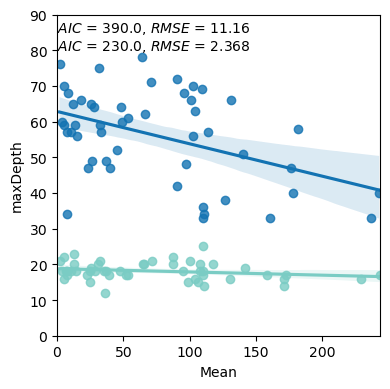

In [26]:
#Correlation with snow depth
fig, ax1 = plt.subplots(1, 1, figsize = (4, 4), 
                #sharex = True, 
                sharey = True, 
                layout = 'tight')
#2023
sns.regplot(data = modDat[modDat.SYear == 2023], x = 'Mean', y = 'maxDepth', order = 1,
                color = pal[4],
                ax = ax1)

#model labels
pCover_SD2023 = smf.ols('maxDepth ~ Mean', data = modDat[modDat.SYear == 2023]).fit()

#2024
sns.regplot(data = modDat[modDat.SYear == 2024], x = 'Mean', y = 'maxDepth', order = 1,
                color = pal[2],
                ax = ax1)

#model labels
pCover_SD2024 = smf.ols('maxDepth ~ Mean', data = modDat[modDat.SYear == 2024]).fit()

#ax1.text(0.6, 85, r'$ p $ = ' + str(round_sig(pOver_SD2023.pvalues.pOverlap, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(pOver_SD2023.rsquared_adj, 2)))
#ax2.text(0.6, 85, r'$ p $ = ' + str(round_sig(pCover_SD2023.pvalues.pCoverage2, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(pCover_SD2023.rsquared_adj, 2)))
#ax1.text(0.6, 80, r'$ p $ = ' + str(round_sig(pOver_SD2024.pvalues.pOverlap, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(pOver_SD2024.rsquared_adj, 2)))
#ax2.text(0.6, 80, r'$ p $ = ' + str(round_sig(pCover_SD2024.pvalues.pCoverage, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(pCover_SD2024.rsquared_adj, 2)))

y2023 =  modDat[modDat.SYear == 2023].maxDepth
y2024 =  modDat[modDat.SYear == 2024].maxDepth
ax1.text(0.05, 85, r'$ AIC $ = ' + str(round_sig(pCover_SD2023.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(y2023, pCover_SD2023.fittedvalues), 4)))
ax1.text(0.05, 80, r'$ AIC $ = ' + str(round_sig(pCover_SD2024.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(y2024, pCover_SD2024.fittedvalues), 4)))

ax1.set_ylim(0, 90)
ax1.set_xlim(0, np.nanmax(modDat.Mean))

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.9186895611775279
Residuals are normally distributed


c:\Users\marie\Desktop\forest-canopy-model\functions.py:450: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  df_results = calculate_residuals(model, features, label)
c:\Users\marie\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


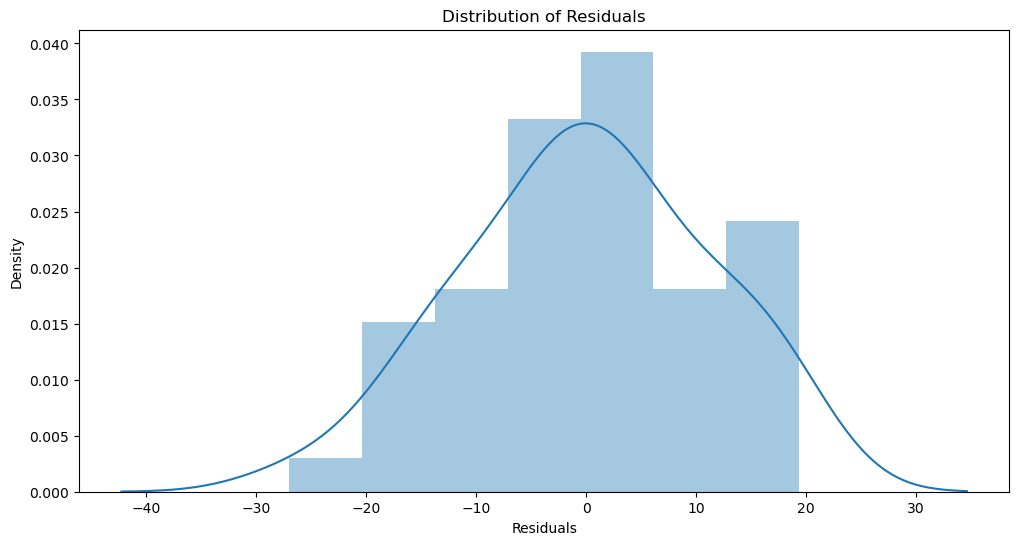


Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.3691419408618535
Signs of positive autocorrelation 

Assumption not satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


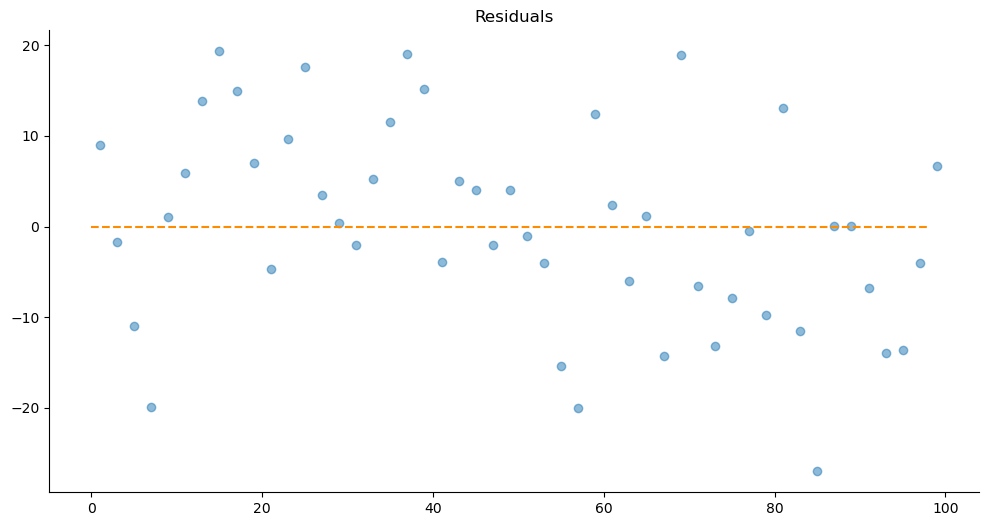

Assumption 2: The error terms are normally distributed 

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\marie\anaconda3\lib\site-packages\patsy\compat.py", line 36, in call_and_wrap_exc
    return f(*args, **kwargs)
  File "c:\Users\marie\anaconda3\lib\site-packages\patsy\eval.py", line 169, in eval
    return eval(code, {}, VarLookupDict([inner_namespace]
  File "<string>", line 1, in <module>
NameError: name 'pCoverage' is not defined

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\marie\anaconda3\lib\site-packages\statsmodels\base\model.py", line 1137, in predict
    exog = dmatrix(design_info, exog, return_type="dataframe")
  File "c:\Users\marie\anaconda3\lib\site-packages\patsy\highlevel.py", line 290, in dmatrix
    (lhs, rhs) = _do_highlevel_design(formula_like, data, eval_env,
  File "c:\Users\marie\anaconda3\lib\site-packages\patsy\highlevel.py", line 167, in _do_highlevel_design
    return build_design_matrices(design_infos, data,
  File "c:\Users\mari

In [42]:
#Check model assumptions
#Overlap Model - 2023
normal_errors_assumption(pOver_SD2023, modDat_site[modDat_site.SYEAR == 2023].pOverlap, modDat_site[modDat_site.SYEAR == 2023].maxSnowDepth)
autocorrelation_assumption(pOver_SD2023, modDat_site[modDat_site.SYEAR == 2023].pOverlap, modDat_site[modDat_site.SYEAR == 2023].maxSnowDepth)
homoscedasticity_assumption(pOver_SD2023, modDat_site[modDat_site.SYEAR == 2023].pOverlap, modDat_site[modDat_site.SYEAR == 2023].maxSnowDepth)

#Coverage Model - 2023
normal_errors_assumption(pCover_SD2023, modDat_site[modDat_site.SYEAR == 2023].pCoverage2, modDat_site[modDat_site.SYEAR == 2023].maxSnowDepth)
autocorrelation_assumption(pCover_SD2023, modDat_site[modDat_site.SYEAR == 2023].pCoverage2, modDat_site[modDat_site.SYEAR == 2023].maxSnowDepth)
homoscedasticity_assumption(pCover_SD2023, modDat_site[modDat_site.SYEAR == 2023].pCoverage2, modDat_site[modDat_site.SYEAR == 2023].maxSnowDepth)

#Overlap Model - 2024
normal_errors_assumption(pOver_SD2024, modDat_site[modDat_site.SYEAR == 2024].pOverlap, modDat_site[modDat_site.SYEAR == 2024].maxSnowDepth)
autocorrelation_assumption(pOver_SD2024, modDat_site[modDat_site.SYEAR == 2024].pOverlap, modDat_site[modDat_site.SYEAR == 2024].maxSnowDepth)
homoscedasticity_assumption(pOver_SD2024, modDat_site[modDat_site.SYEAR == 2024].pOverlap, modDat_site[modDat_site.SYEAR == 2024].maxSnowDepth)

#Coverage Model - 2024
normal_errors_assumption(pCover_SD2024, modDat_site[modDat_site.SYEAR == 2024].pCoverage, modDat_site[modDat_site.SYEAR == 2024].maxSnowDepth)
autocorrelation_assumption(pCover_SD2024, modDat_site[modDat_site.SYEAR == 2024].pCoverage, modDat_site[modDat_site.SYEAR == 2024].maxSnowDepth)
homoscedasticity_assumption(pCover_SD2024, modDat_site[modDat_site.SYEAR == 2024].pCoverage, modDat_site[modDat_site.SYEAR == 2024].maxSnowDepth)

Text(0.5, 0, 'Proportion of Codominant Trees')

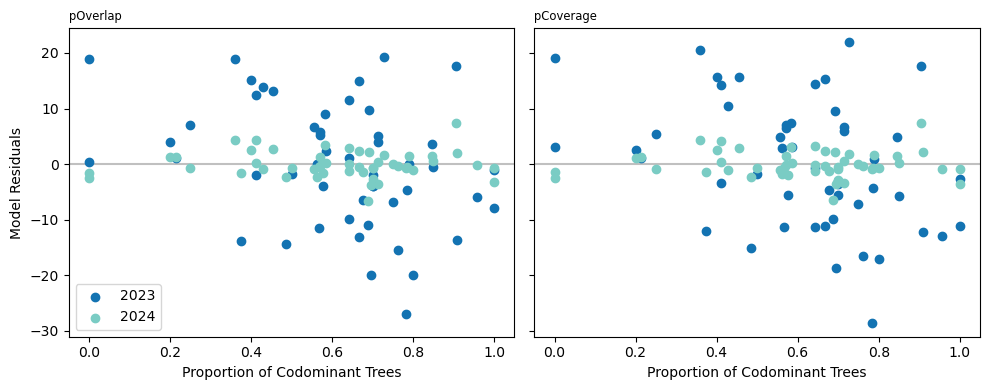

In [43]:
#2D model error overestimation
fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (10, 4), 
                               sharex = True, 
                               sharey = True, 
                               layout = 'tight')

ax1.axhline(0, color = 'silver')
ax2.axhline(0, color = 'silver')

#pOverlap
#2023
ax1.scatter(modDat_site[modDat_site.SYEAR == 2023].pCo, pOver_SD2023.resid, color = pal[4], 
           zorder = 2, label = '2023')
#2024
ax1.scatter(modDat_site[modDat_site.SYEAR == 2024].pCo, pOver_SD2024.resid, color = pal[2], 
           zorder = 2, label = '2024')

#pCoverage
#2023
ax2.scatter(modDat_site[modDat_site.SYEAR == 2023].pCo, pCover_SD2023.resid, color = pal[4], 
           zorder = 2, label = '2023')
#2024
ax2.scatter(modDat_site[modDat_site.SYEAR == 2024].pCo, pCover_SD2024.resid, color = pal[2], 
           zorder = 2, label = '2024')

ax1.legend()
ax1.set_title('pOverlap', loc = 'left', size = 'small')
ax2.set_title('pCoverage', loc = 'left', size = 'small')
ax1.set_ylabel('Model Residuals')
ax1.set_xlabel('Proportion of Codominant Trees')
ax2.set_xlabel('Proportion of Codominant Trees')

(0.0, 90.0)

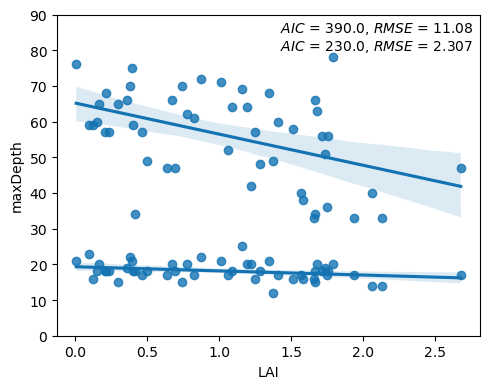

In [29]:
#Correlation with snow depth (original LAI values)
fig, ax1 = plt.subplots(1, 1, figsize = (5, 4), 
                sharex = True, 
                sharey = True, 
                layout = 'tight')
#2023
#average points
sns.regplot(data = modDat[modDat.SYear == 2023], x = 'LAI', y = 'maxDepth', order = 1,
                color = pal[4],
                ax = ax1)

#model labels
LAI_SD2023 = smf.ols('maxDepth ~ LAI', data = modDat[modDat.SYear == 2023]).fit()

#2024
#average points
sns.regplot(data = modDat[modDat.SYear == 2024], x = 'LAI', y = 'maxDepth', order = 1,
                color = pal[4],
                ax = ax1)
#model labels
LAI_SD2024 = smf.ols('maxDepth ~ LAI', data = modDat[modDat.SYear == 2024]).fit()

ax1.text(1.42, 85, r'$ AIC $ = ' + str(round_sig(LAI_SD2023.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(y2023, LAI_SD2023.fittedvalues), 4)))
ax1.text(1.42, 80, r'$ AIC $ = ' + str(round_sig(LAI_SD2024.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(y2024, LAI_SD2024.fittedvalues), 4)))

ax1.set_ylim(0, 90)